## Weblog Analysis

Install all the required packages.

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 kB 3.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 12.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

## Liten
Import liten. Get session and database for storage.
#### Database
Liten database stores all data in vector (1-D tensor) format. If a schema is provided it stores data in a generalized tensor format. When working with spark, Liten is a data layer between storage and Spark processing.
#### Session
Liten session keeps track of all the work. It stores session and model information in Liten database.

In [2]:
import liten as ten
session = ten.Session()
db = ten.Database()

Started _liten_session_start=1 desc=Default session


Check python and Ipython versions

In [3]:
import os
from platform import python_version
python_version()

'3.10.9'

In [4]:
import IPython
IPython.sys_info()

"{'commit_hash': '87b7b87',\n 'commit_source': 'installation',\n 'default_encoding': 'utf-8',\n 'ipython_path': '/opt/conda/lib/python3.10/site-packages/IPython',\n 'ipython_version': '8.11.0',\n 'os_name': 'posix',\n 'platform': 'Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35',\n 'sys_executable': '/opt/conda/bin/python',\n 'sys_platform': 'linux',\n 'sys_version': '3.10.9 | packaged by conda-forge | (main, Feb  2 2023, '\n                '20:20:04) [GCC 11.3.0]'}"

Start a spark session. Spark application name is litendata.

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib
%matplotlib inline

spark = SparkSession.builder.master("local[1]") \
                    .appName('litendata.com') \
                    .getOrCreate()

Check if Spark looks fine with sample data set.

In [6]:
data = [("James","","Smith","36636","M",3000),
    ("Michael","Rose","","40288","M",4000),
    ("Robert","","Williams","42114","M",4000),
    ("Maria","Anne","Jones","39192","F",4000),
    ("Jen","Mary","Brown","","F",-1)
  ]

schema = StructType([ \
    StructField("firstname",StringType(),True), \
    StructField("middlename",StringType(),True), \
    StructField("lastname",StringType(),True), \
    StructField("id", StringType(), True), \
    StructField("gender", StringType(), True), \
    StructField("salary", IntegerType(), True) \
  ])
 
df = spark.createDataFrame(data=data,schema=schema)
df.printSchema()
df.show(n=10,truncate=False)


root
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- salary: integer (nullable = true)

+---------+----------+--------+-----+------+------+
|firstname|middlename|lastname|id   |gender|salary|
+---------+----------+--------+-----+------+------+
|James    |          |Smith   |36636|M     |3000  |
|Michael  |Rose      |        |40288|M     |4000  |
|Robert   |          |Williams|42114|M     |4000  |
|Maria    |Anne      |Jones   |39192|F     |4000  |
|Jen      |Mary      |Brown   |     |F     |-1    |
+---------+----------+--------+-----+------+------+



### Web log debug

For looking at weblog file, we will load and analyze a sample file. In this sample log file, these are the fields present.
Weblog lines

Field | Description                            |
------|----------------------------------------|
IP    | Remote host IP number                  |
Time  | Time at which the request was sent     |
URL   | A Restfule request like GET, POST etc. |
Status| Status response for the request        |


In [7]:
weblog_schema = StructType([ \
    StructField("IP",StringType(),True), \
    StructField("Time",TimestampType(),True), \
    StructField("URL",StringType(),True), \
    StructField("Status", IntegerType(), True)
                           ])

Read from a sample weblog file

In [8]:
weblog_df = spark.read.format('csv').options(header='true').options(delimiter=',').options(timestampFormat='dd/MMM/yyyy:HH:mm:ss').schema(weblog_schema).load("weblog.csv")
weblog_df.createOrReplaceTempView("weblog")
weblog_df.printSchema()
weblog_df.take(5)

root
 |-- IP: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- URL: string (nullable = true)
 |-- Status: integer (nullable = true)



[Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 58, 55), URL='GET /login.php HTTP/1.1', Status=200),
 Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 2), URL='POST /process.php HTTP/1.1', Status=302),
 Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 3), URL='GET /home.php HTTP/1.1', Status=200),
 Row(IP='10.131.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 4), URL='GET /js/vendor/moment.min.js HTTP/1.1', Status=200),
 Row(IP='10.130.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 6), URL='GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1', Status=200)]

Start a new debug query. Examine the log file. Ask codriver on possible mistakes made in weblog files.

In [9]:
session.new()

Stopped _liten_session_end=1
Started _liten_session_start=2 desc=New interactive session


In [10]:
cntDf = spark.sql("select count(*) from weblog")
cntDf.show()

+--------+
|count(1)|
+--------+
|   15964|
+--------+



In [11]:
session.complete_chat("Weblog is a log file generated by servers. Can you explain its different fields? Please list top three errors and failures encountered in weblog.")

'\n\nA web log (or “weblog”) is a log file generated by a web server that records all requests made to it. It typically includes information such as the client IP address, the request type, the requested URL, the HTTP status code, and the size of the response.\n\nThe top three errors and failures encountered in weblog are:\n\n1. HTTP 404 Not Found Error: This occurs when a client requests a URL that does not exist on the web server.\n\n2. HTTP 500 Internal Server Error: This occurs when the web server encounters an unexpected condition that prevents it from fulfilling the request.\n\n3. HTTP 400 Bad Request Error: This occurs when the client sends an invalid request to the server.'

List all  404 errors. See how many occured.

In [12]:
session.new()

Stopped _liten_session_end=2
Started _liten_session_start=3 desc=New interactive session


In [13]:
session.generate_sql("Count number of rows from weblog table where Status column has 404 errors")

'\n\nThis request is asking for a count of the number of rows in the weblog table where the Status column contains a 404 error.'

In [14]:
sqlDf=spark.sql("SELECT COUNT(*) FROM weblog WHERE Status = 404;")
sqlDf.show()

+--------+
|count(1)|
+--------+
|     251|
+--------+



List all 500 errors, these are server side errors.

In [15]:
session.new()

Stopped _liten_session_end=3
Started _liten_session_start=4 desc=New interactive session


In [16]:
session.generate_sql("Count number of rows from weblog table where Status column has 500 errors")

'\n\nThis request is asking to count the number of rows in the weblog table where the Status column has a value of 500.'

In [17]:
sqlDf=spark.sql("SELECT COUNT(*) FROM weblog WHERE Status = '500';")
sqlDf.show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



Connection timed out errors. See if they are in the log file.

In [18]:
session.new()

Stopped _liten_session_end=4
Started _liten_session_start=5 desc=New interactive session


In [19]:
session.generate_sql("Count number of rows from weblog table where Status column is equal to  http status code for request timeout")

'\n\nThis request is asking to count the number of rows in the weblog table where the Status column is equal to 408, which is the HTTP status code for a request timeout.'

In [20]:
sqlDf=spark.sql("SELECT COUNT(*) FROM weblog WHERE Status = '408';")
sqlDf.show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [21]:
session.new()

Stopped _liten_session_end=5
Started _liten_session_start=6 desc=New interactive session


Start a debug session, Get all redirection messages (3xx returns)

In [22]:
st3xxDf = spark.sql("SELECT Status, COUNT(*) FROM weblog WHERE Status LIKE '3%%' GROUP BY Status")
st3xxDf.show()

+------+--------+
|Status|count(1)|
+------+--------+
|   304|     658|
|   302|    3498|
+------+--------+



In [23]:
session.new()

Stopped _liten_session_end=6
Started _liten_session_start=7 desc=New interactive session


Let us look at some traffic and plots

In [24]:
st17Df = spark.sql("SELECT * FROM weblog WHERE Time <= '2021-12-31'")
st17Df.take(2)

[Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 58, 55), URL='GET /login.php HTTP/1.1', Status=200),
 Row(IP='10.128.2.1', Time=datetime.datetime(2017, 11, 29, 6, 59, 2), URL='POST /process.php HTTP/1.1', Status=302)]

<Axes: xlabel='Time'>

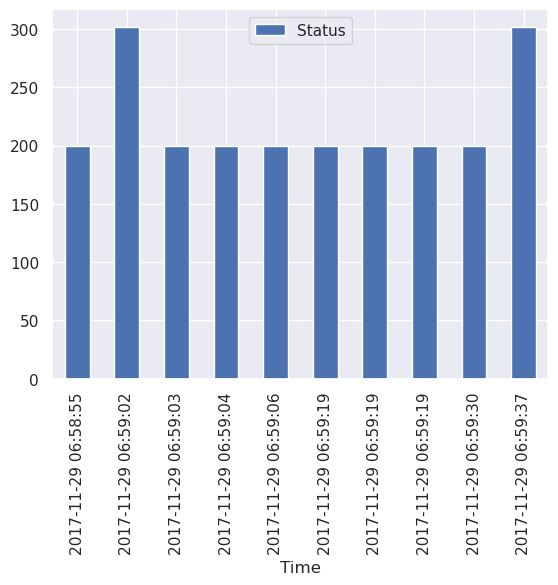

In [25]:
pandas_df = st17Df.toPandas()
pandas_df.iloc[:10].plot(x="Time",y="Status",kind='bar')

Stop all sessions and analyze all so far

In [26]:
session.stop()

Stopped _liten_session_end=7


Recap what was done and see if we can redo if needed.

In [ ]:
session.explain(5)

In [ ]:
session.replay(6)

In [ ]:
session.new()
#session.generate_sql("Count number of rows from weblog table where Status column is equal to  http status code for request timeout")
sqlDf=spark.sql("SELECT COUNT(*) FROM weblog WHERE Status = 408;")
sqlDf.show()

In [ ]:
TBD - Find similar sessions...